# Evaluate Policy-Gradient Agent

## PG-based DroneLeader

We implement a DroneLeader using a 3-layer CNN using REINFORCE policy gradient RL algorithm. The drone leader has complete observation of the game space.

we discovered that a drone leader based on very advanced NN with complete observation of the game space, is not able to overcome the problems of local optima and sparce reward. In addition, it learns a very brittle policy of always going back to the same general area of the 1st food pile, even when the map has completely changed (and the food pile is no longer at the same spot). 

In [1]:
import os
import random
import time
import platform
import torch
import torch.optim as optim
import gym
import numpy as np
import pickle
import pandas as pd

# This is the Crossing game environment
from xteams_env import CrossingEnv
from xteams_model import *
from interface import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


In [2]:
"""
We seperate out the models of drone leaders and crawler followers so that we can mix and match trained models
in game plays.
"""

droneleader_PG_models = [
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_coop/t1.5_rp-1.0_300gs/",  # model 1
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t1.5_rp-1.0_300gs/",   # model 2 
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t2.0_rp-1.0_300gs/",   # model 3  
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples/t2.0_rp-1.0_300gs/",   # model 4
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples_teamreward/t2.0_rp-1.0_300gs/",   # model 5
    "models/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 6
    "models/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_8/t2.0_rp-1.0_300gs/", # model 7
    "models/1T-1L/pg_droneleader_2000/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 8
    "models/1T-1L/pg_droneleader_test/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 9
]

droneleader_PG_params = [
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 8},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
]

droneleader_fc32_models = [
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_0/t2.0_rp-1.0_300gs/",   # model 1
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_7/t2.0_rp-1.0_300gs/",   # model 2
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_54/t2.0_rp-1.0_300gs/",  # model 3
]

droneleader_fc32_params = [
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 0},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 54}
]

droneleader_fc64_models = [
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/",   # model 1
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # model 2
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/",   # model 3
    "models/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # model 4
    "models/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/",  # model 5
    "models/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_80/t2.0_rp-1.0_300gs/",   # model 6 
]

droneleader_fc64_params = [
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 0},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 54},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 54},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 80},
]

results/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_8/t2.0_rp-1.0_300gs/
results/1T-1L/pg_droneleader_2000/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/pg_droneleader_test/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/


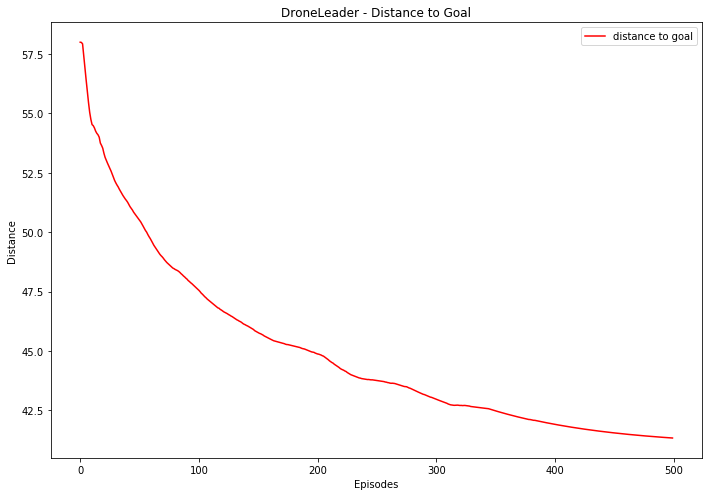

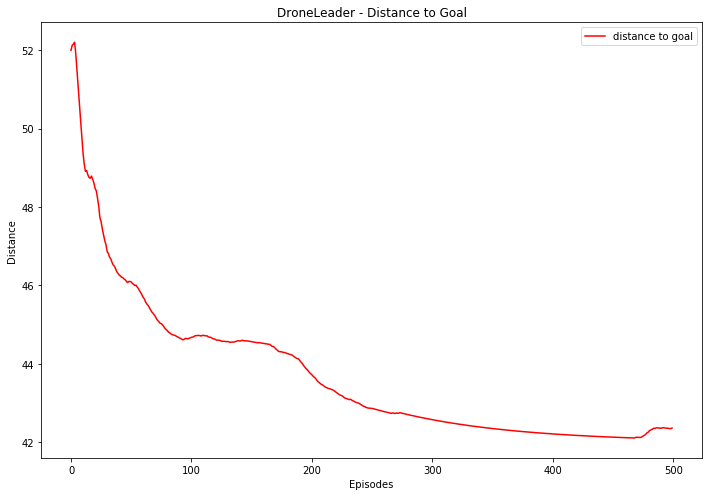

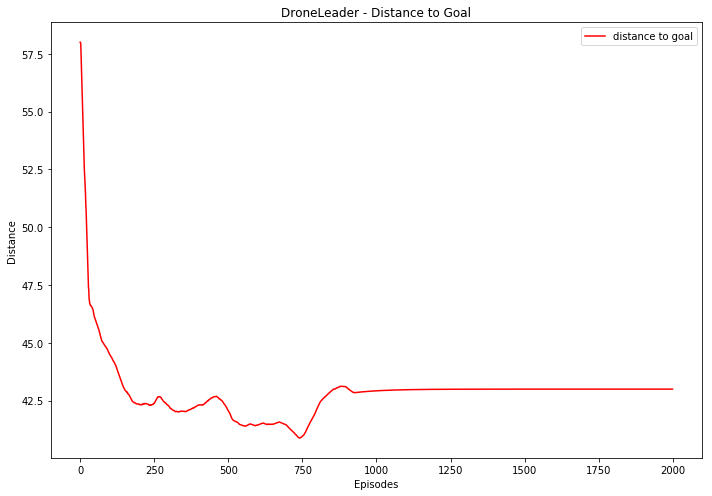

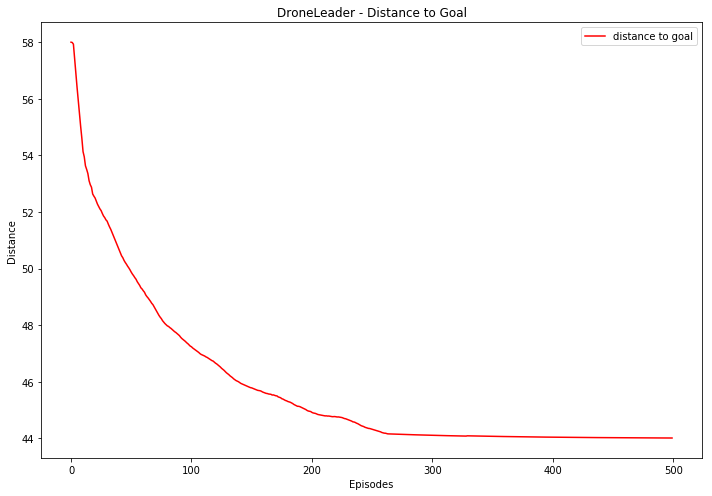

In [3]:
game = 'Crossing'

############# 1T1L Strategist + Simple DroneLeader #############
dir_names = [
    "results/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 6
    "results/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_8/t2.0_rp-1.0_300gs/", # model 7
    "results/1T-1L/pg_droneleader_2000/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 8
    "results/1T-1L/pg_droneleader_test/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 9
]

data = []

for i, dir_name in enumerate(dir_names):
    print (dir_name)
   
    delta_file = dir_name+'Delta.p'.format(i, game)
    with open(delta_file, 'rb') as f:
        data.append(pickle.load(f))
            

for delta in data:
    plt.figure(figsize=(10, 7))

    plt.plot(delta, label='distance to goal', color='red')


    plt.title('DroneLeader - Distance to Goal')
    plt.xlabel('Episodes')
    plt.ylabel('Distance')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Play 1 Game

We play 1 game by randomly selecting from 1 of 24 maps and 1 of 12 start position for the agent.

In [5]:
from torch.autograd import Variable

game = 'Crossing'

maps = [
        'maps/food_d37_river_w1_d25_v1.txt',
        'maps/food_d37_river_w1_d25_v2.txt',
        'maps/food_d37_river_w1_d25_v3.txt',
        'maps/food_d37_river_w1_d25_v4.txt',
        'maps/food_d37_river_w1_d25_v5.txt',
        'maps/food_d37_river_w1_d25_v6.txt',
        'maps/food_d37_river_w1_d25_v7.txt',
        'maps/food_d37_river_w1_d25_v8.txt',
        'maps/food_d37_river_w1_d25_v9.txt',
        'maps/food_d37_river_w1_d25_v10.txt',
        'maps/food_d37_river_w1_d25_v11.txt',
        'maps/food_d37_river_w1_d25_v12.txt',
        'maps/food_d37_river_w1_d25_v13.txt',
        'maps/food_d37_river_w1_d25_v14.txt',
        'maps/food_d37_river_w1_d25_v15.txt',
        'maps/food_d37_river_w1_d25_v16.txt',
        'maps/food_d37_river_w1_d25_v17.txt',
        'maps/food_d37_river_w1_d25_v18.txt',
        'maps/food_d37_river_w1_d25_v19.txt',
        'maps/food_d37_river_w1_d25_v20.txt',
        'maps/food_d37_river_w1_d25_v21.txt',
        'maps/food_d37_river_w1_d25_v22.txt',
        'maps/food_d37_river_w1_d25_v23.txt',
        'maps/food_d37_river_w1_d25_v24.txt',
]

starts = [
    (1,1),
    (1,9),
    (1,18),
    (20,1),
    (20,9),
    (20,18),
    (40,1),
    (40,9),
    (40,18),
    (57,1),
    (57,9),
    (57,18),
]

# droneleader_start = starts[random.randint(0,len(starts)-1)]
# map_name = maps[random.randint(0,len(maps)-1)]

map_name = maps[0]
droneleader_start = starts[0]
print("Drone starts at {} in map {}.".format(droneleader_start, map_name))

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 8
dir_name = droneleader_PG_models[scenario-1]
parameter = droneleader_PG_params[scenario-1]
episodes = 500  # This is used to recall a model file trained to a # of episodes

# There will be 1 agents - 1 teams of 1 AI agents each and 0 random agent
num_ai_agents = 1
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

# Scenario 26-33
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},        
]

agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': droneleader_start}
]


# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions
num_goal_params = 2       # 2 parameters in Goal (delta coordinates)

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 100

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_ai_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
if episodes > 0:
    agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA0_{}_ep{}.p'.format(game,episodes)
        try:
            with open(model_file, 'rb') as f:
                
                print("Load saved model for agent {}".format(i))
                
                # Load agent policy based on type
                if agents_params[i]['type'] is 'crawler':
                    agent = Crawler_Policy(num_frames, num_crawler_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    print("Load Drone Leader.")
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                else:
                    raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                optimizer = optim.Adam(agent.parameters(), lr=0.1)

                # New way to save and load models - based on: 
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                _ = load_model(agent, optimizer, f, device=device)
                agent.eval()
                agents[i] = agent
        except OSError:
            print('Model file not found.')
            raise
else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load AI agent {}".format(i))
        if agents_params[i]['type'] is 'drone':
            agents.append(Drone_Policy(num_frames, num_drone_actions, i))
        elif agents_params[i]['type'] is 'crawler':
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
        else:
            raise Exception('Invalid type for agent {}: {}'.format(i,agents_params[i]['type']))

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load random agent {}".format(i))
    agents.append(Rdn_Policy())

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))

# 5-29-2019  Strategist accepts directorship of a team
suntzu = Strategist()
suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
    game_space = agents_obs[suntzu.eyes[0].idx]
    goals, topology = suntzu.generate_goals(game_space)
    deltas = calc_deltas(goals[0], env.agent_locations[0])
        
    for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i in range(num_ai_agents):    # For AI agents
            if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                # PG_based droneleaders requires obs space as input
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            else:    
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_ai_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])        
        
        for i in range(num_agents):
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
        total = 0
        for i in range(num_ai_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i in range(num_ai_agents):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agents_params[i]['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/(frame+1e-7)))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        print('US agents hit = {}'.format(agent_US_hits))
        print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nProximity Metric')
print ('================')

target_x, target_y = goals[0]
current_x, current_y = env.agent_locations[0]
episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
print ('Start = {}'.format(droneleader_start))
print ('(x_Fmax,y_Fmax) = {}'.format(goals[0]))
print ('(x_a,y_a) = {}'.format(env.agent_locations[0]))
print ('Distance from Goal = {}'.format(episode_delta))

Drone starts at (1, 1) in map maps/food_d37_river_w1_d25_v1.txt.
Load saved model for agent 0
Load Drone Leader.

Statistics by Agent
Agent0 reward is 0

Proximity Metric
Start = (1,1)
(x_Fmax,y_Fmax) = (34,24)
(x_a,y_a) = (34,24)
Distance from Goal = 40


## Repeated Game Plays

In [4]:
from torch.autograd import Variable

game = 'Crossing'

maps = [
        'maps/food_d37_river_w1_d25_v1.txt',
        'maps/food_d37_river_w1_d25_v2.txt',
        'maps/food_d37_river_w1_d25_v3.txt',
        'maps/food_d37_river_w1_d25_v4.txt',
        'maps/food_d37_river_w1_d25_v5.txt',
        'maps/food_d37_river_w1_d25_v6.txt',
        'maps/food_d37_river_w1_d25_v7.txt',
        'maps/food_d37_river_w1_d25_v8.txt',
        'maps/food_d37_river_w1_d25_v9.txt',
        'maps/food_d37_river_w1_d25_v10.txt',
        'maps/food_d37_river_w1_d25_v11.txt',
        'maps/food_d37_river_w1_d25_v12.txt',
        'maps/food_d37_river_w1_d25_v13.txt',
        'maps/food_d37_river_w1_d25_v14.txt',
        'maps/food_d37_river_w1_d25_v15.txt',
        'maps/food_d37_river_w1_d25_v16.txt',
        'maps/food_d37_river_w1_d25_v17.txt',
        'maps/food_d37_river_w1_d25_v18.txt',
        'maps/food_d37_river_w1_d25_v19.txt',
        'maps/food_d37_river_w1_d25_v20.txt',
        'maps/food_d37_river_w1_d25_v21.txt',
        'maps/food_d37_river_w1_d25_v22.txt',
        'maps/food_d37_river_w1_d25_v23.txt',
        'maps/food_d37_river_w1_d25_v24.txt',
]

starts = [
    (1,1),
    (1,9),
    (1,18),
    (20,1),
    (20,9),
    (20,18),
    (40,1),
    (40,9),
    (40,18),
    (57,1),
    (57,9),
    (57,18),
]

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 8
dir_name = droneleader_PG_models[scenario-1]
parameter = droneleader_PG_params[scenario-1]
episodes = 500  # This is used to recall a model file trained to a # of episodes

# Initialize environment
render = False
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions
num_goal_params = 2       # 2 parameters in Goal (delta coordinates)
river_penalty = -1

# Initialize constants
num_frames = 7
max_episodes = 100  # Run 100 episode for each map
max_frames = 100

# There will be 1 agents - 1 teams of 1 AI agents each and 0 random agent
num_ai_agents = 1
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Metric
total_delta = 0
total_eps = 0
map_deltas = [[] for map in maps]  # for storing deltas by map

start = time.clock()

for map_num, map_name in enumerate(maps):    # For each map
    map_total_delta = 0
    map_total_eps = 0
    
    for ep in range(max_episodes):   # Run a number of game plays using random agent start positions
        print('.', end='')  # To show progress
        total_eps += 1
        map_total_eps += 1

        # Data structure for AI agents (agents will form their own Class later on)
        agents = []
        actions = []

        # Set up parameters of agents and teams as inputs into CrossingEnv

        # Scenario 26-33
        teams_params = [
            {'name': 'Vikings', 'color': 'deepskyblue', 
             'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
             'roles': ['leader','follower'],
             'target_zone': None, 'banned_zone': None},        
        ]
    
        droneleader_start = starts[random.randint(0,len(starts)-1)]
        agents_params = [
            {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
             'role': 'leader', 'start': droneleader_start}
        ]
        # print("Drone starts at {} in map {}.".format(droneleader_start, map_name))
        
        agents= [[] for i in range(num_ai_agents)]
        # If episodes is provided (not 0), load the model for each AI agent
        for i in range(num_ai_agents):
            model_file = dir_name+'MA0_{}_ep{}.p'.format(game,episodes)
            try:
                with open(model_file, 'rb') as f:
                    # Load agent policy based on type
                    if agents_params[i]['type'] is 'crawler':
                        agent = Crawler_Policy(num_frames, num_crawler_actions, i)
                    elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                        agent = Drone_Policy(num_frames, num_drone_actions, i)
                    elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                        agent = Drone_Policy(num_frames, num_drone_actions, i)
                    else:
                        raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                    optimizer = optim.Adam(agent.parameters(), lr=0.1)

                    # New way to save and load models - based on: 
                    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                    _ = load_model(agent, optimizer, f, device=device)
                    agent.eval()
                    agents[i] = agent
            except OSError:
                print('Model file not found.')
                raise

        # Load random agents    
        for i in range(num_ai_agents,num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

        # Initialize AI and random agent data
        actions = [0 for i in range(num_agents)]

        # Attach agents to their teams
        # 4-28-2019 Add roles and types to enable multi-role teams

        teams = []

        # Team Vikings
        teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))

        # 5-29-2019  Strategist accepts directorship of a team
        suntzu = Strategist()
        suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

        env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   

        env_obs = env.reset()  # Environment return observations
        """
        # For Debug only
        print (len(agents_obs))
        print (agents_obs[0].shape)
        """
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
    
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])
        
        for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
            agents[i].reset_info()    
    
        if render:
            env.render()  
            time.sleep(SPEED)  # Change speed of video rendering
    
        """

        """
        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)    
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # Reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        """

        for frame in range(max_frames):

            for i in range(num_ai_agents):    # For AI agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    # PG_based droneleaders requires obs space as input
                    actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
                else:    
                    actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
                
            for i in range(num_ai_agents, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
        
            """
            For now, we do not implement LSTM
            # Select action
            action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
            """

            # if frame % 10 == 0:
            #     print (actions)    
        
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """

            for i in range(num_ai_agents):
                agents[i].rewards.append(reward[i])  # Stack rewards

        
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
            # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_deltas(goals[0], env.agent_locations[0])        
           
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            total = 0
            for i in range(num_ai_agents):
                agent_reward = sum(agents[i].rewards)
                total += agent_reward
        
            if render:
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering        

            if any(done):
                print("Done after {} frames".format(frame))
                break

        env.close()  # Close the rendering window

        start_x, start_y = droneleader_start
        target_x, target_y = goals[0]
        current_x, current_y = env.agent_locations[0]
        episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
        
        total_delta += episode_delta
        map_total_delta += episode_delta
        map_deltas[map_num].append(episode_delta)
        
    # Print out statistics of the agent for the map
    print ('\nProximity Metric')
    print ('================')
    print ('For map {}'.format(map_name))
    map_av_delta = map_total_delta/map_total_eps 
    print ('Distance from Goal = {}'.format(map_av_delta))

end = time.clock()
print('\nTraining time: {:.2f} min'.format((end-start)/60.0))

print ('\nProximity Metric')
print ('================')
average_delta = total_delta/total_eps
print ('Distance from Goal = {}'.format(average_delta))

....................................................................................................
Proximity Metric
For map maps/food_d37_river_w1_d25_v1.txt
Distance from Goal = 24.03
....................................................................................................
Proximity Metric
For map maps/food_d37_river_w1_d25_v2.txt
Distance from Goal = 24.61
....................................................................................................
Proximity Metric
For map maps/food_d37_river_w1_d25_v3.txt
Distance from Goal = 32.09
....................................................................................................
Proximity Metric
For map maps/food_d37_river_w1_d25_v4.txt
Distance from Goal = 24.35
....................................................................................................
Proximity Metric
For map maps/food_d37_river_w1_d25_v5.txt
Distance from Goal = 26.54
.................................................................

In [36]:
env.close()

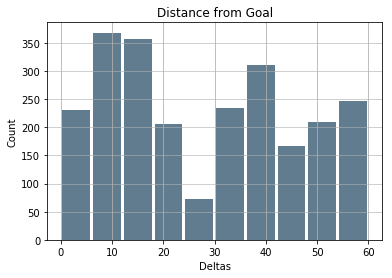

In [5]:
import pandas as pd


commutes = pd.Series(np.asarray(map_deltas).reshape(-1))

commutes.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.title('Distance from Goal')
plt.xlabel('Deltas')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

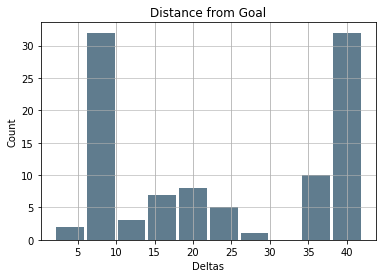

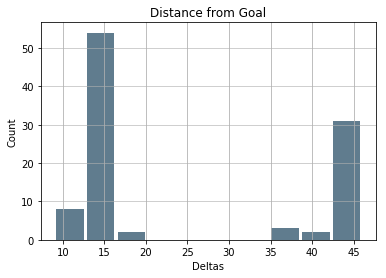

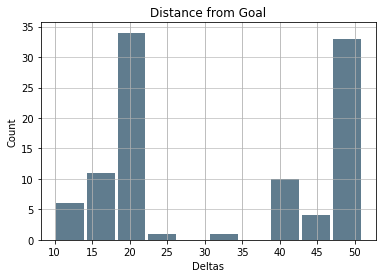

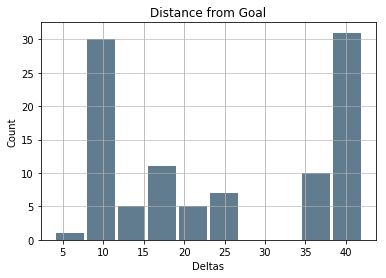

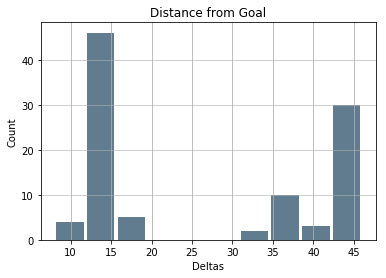

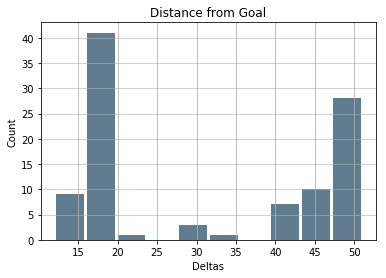

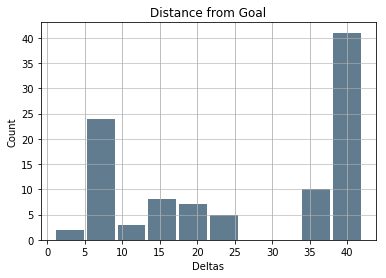

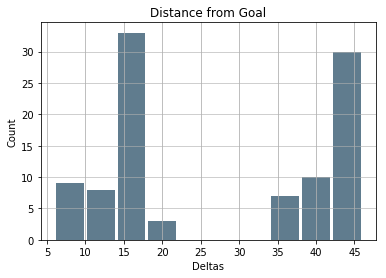

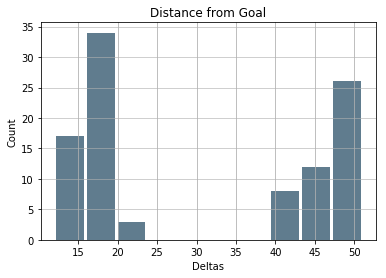

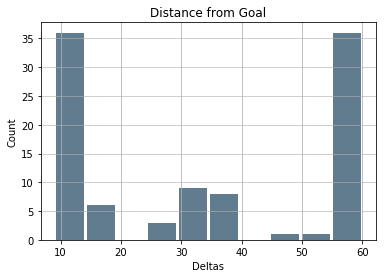

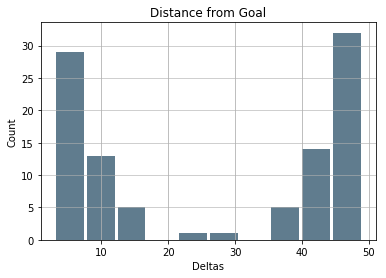

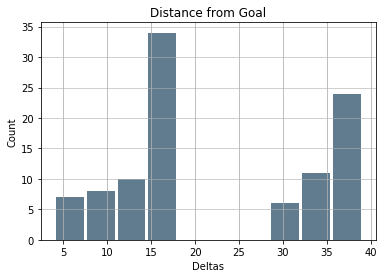

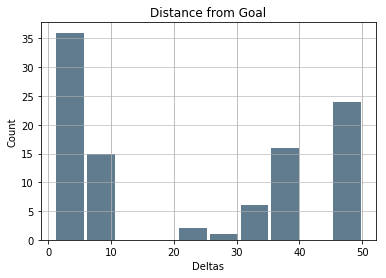

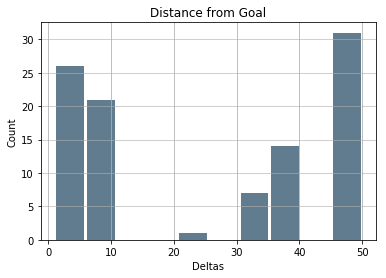

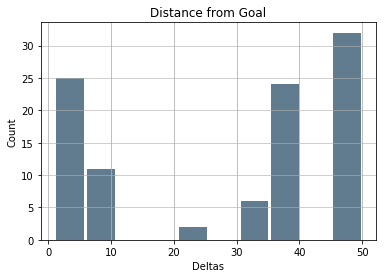

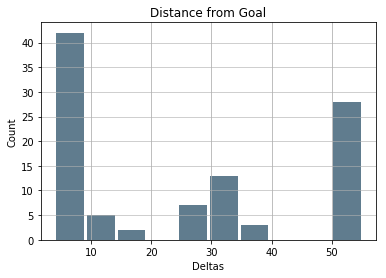

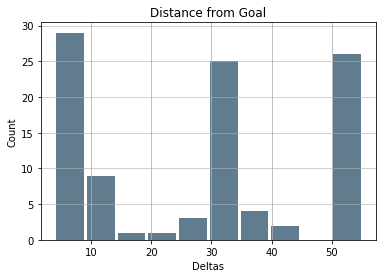

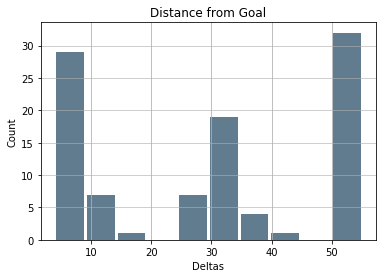

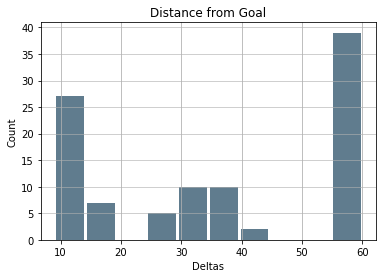

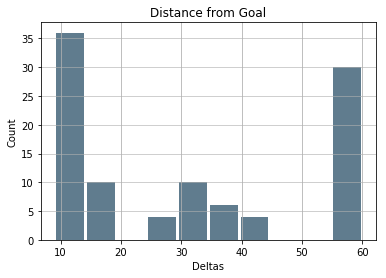

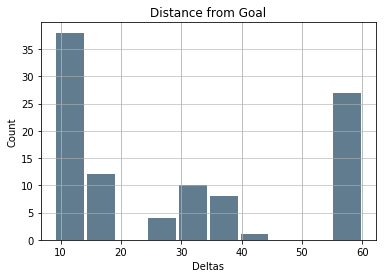

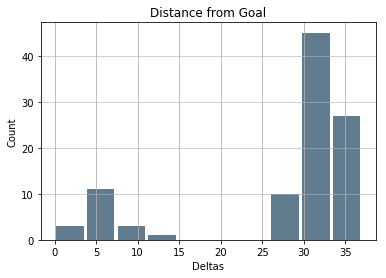

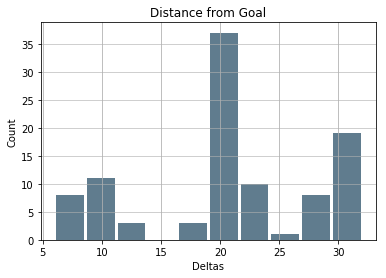

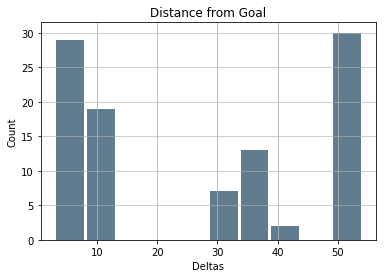

In [6]:
for i in range(len(map_deltas)):
    commutes = pd.Series(np.asarray(map_deltas[i]).reshape(-1))

    commutes.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
    plt.title('Distance from Goal')
    plt.xlabel('Deltas')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [8]:
data_file = 'results/1T-1L/pg_droneleader_2000/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/Repeated_Play_Deltas.p'
with open(data_file, 'wb') as f:
    pickle.dump(map_deltas, f)

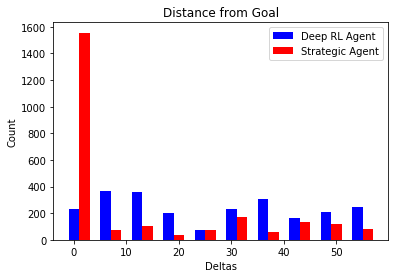

In [21]:
data_file = 'results/1T-1L/pg_droneleader_2000/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/Repeated_Play_Deltas.p'
with open(data_file, 'rb') as f: 
    data1 = pickle.load(f)

data_file = 'results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/Repeated_Play_Deltas.p'
with open(data_file, 'rb') as f: 
    data2 = pickle.load(f)

# deltas = pd.Series(np.asarray(data).reshape(-1))

deltas = pd.DataFrame({'a': np.asarray(data1).reshape(-1), 'b': np.asarray(data2).reshape(-1)}, columns=['a','b'])

fig, ax = plt.subplots()

plt.title('Distance from Goal')
plt.xlabel('Deltas')
plt.ylabel('Count')

a_heights, a_bins = np.histogram(deltas['a'])
b_heights, b_bins = np.histogram(deltas['b'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='blue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='red')

ax.legend(["Deep RL Agent","Strategic Agent"])

In [16]:
width

2.0